1. Calculate the trend in the Fire Weather Index (FWI) using the provided data. Include in your submission your code or description of processing, a map showing the trend,  and a chart of the trend for each province.

In [1]:
pip install geopandas rasterio numpy matplotlib rasterstats

     ---------------------------------------- 0.0/58.1 kB ? eta -:--:--
     -------------------- ----------------- 30.7/58.1 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 58.1/58.1 kB 772.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.5 MB 1.9 MB/s eta 0:00:13
   ---------------------------------------- 0.1/24.5 MB 1.1 MB/s eta 0:00:24
   ---------------------------------------- 0.2/24.5 MB 1.5 MB/s eta 0:00:16
    --------------------------------------- 0.3/24.5 MB 1.6 MB/s eta 0:00:16
    --------------------------------------- 0.4/24.5 MB 1.6 MB/s eta 0:00:15
    --------------------------------------- 0.5/24.5 MB 1.7 MB/s eta 0:00:15
   - -------------------------------------- 0.6/24.5 MB 1.8 MB/s eta 0:00:13
   - -------------------------------------- 0.7/24.5 MB 1.8 MB/s eta 0:00:13
   - -------------------------------------- 0.8/24.5 MB 1.9 MB/s eta 0:00:13
   - 

Columns in shapefile: Index(['feature_id', 'juri', 'juri_en', 'juri_fr', 'bodt', 'bodt_en',
       'bodt_fr', 'ctry', 'ctry_en', 'ctry_fr', 'map_sel', 'map_sel_en',
       'map_sel_fr', 'geometry'],
      dtype='object')


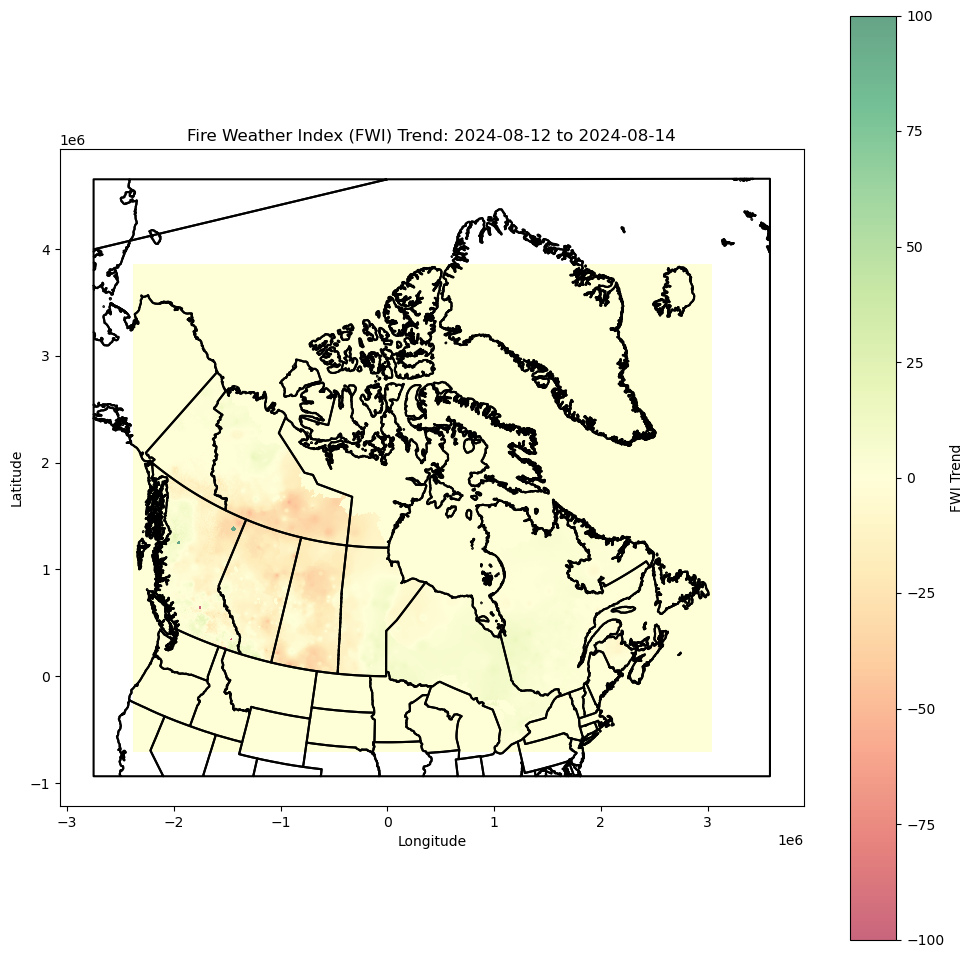

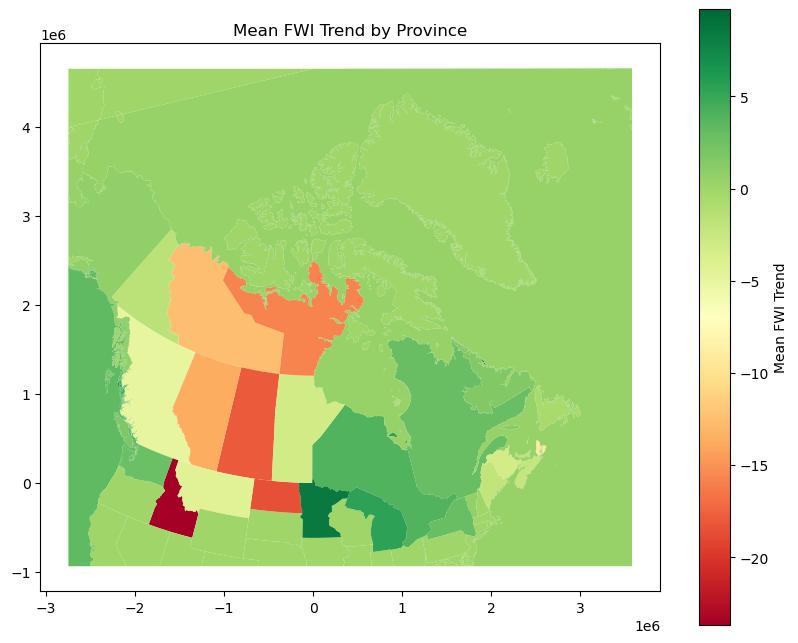

               juri_en  mean_fwi_trend
0              Nunavut        0.000000
1     British Columbia        5.496404
2            Greenland        0.000000
3             Scotland        0.000000
4              Nunavut        0.000000
...                ...             ...
1142          Chukotka        0.000000
1143          Chukotka        0.000000
1144    Not Identified        0.495111
1145          Chukotka        0.000000
1146          Chukotka        0.000000

[1147 rows x 2 columns]


In [41]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import os
import pandas as pd
from rasterio import Affine

# File paths for the TIFF files and shapefile
fwi_tif1_path = r'C:\PBN\Resume\NRCAN Fire Research Analyst\Exam\fwi20240812.tif'  # Replace with actual path
fwi_tif2_path = r'C:\PBN\Resume\NRCAN Fire Research Analyst\Exam\\fwi20240814.tif'  # Replace with actual path
shapefile_path = r'C:\PBN\Resume\NRCAN Fire Research Analyst\Exam\canvec_5M_CA_Admin_shp\canvec_5M_CA_Admin\geo_political_region_2.shp'  # Replace with actual path

# Step 1: Check if the raster files exist
if not os.path.exists(fwi_tif1_path) or not os.path.exists(fwi_tif2_path):
    print("Raster file paths are incorrect or files are missing.")
else:
    try:
        # Load the FWI raster files
        with rasterio.open(fwi_tif1_path) as src1, rasterio.open(fwi_tif2_path) as src2:
            fwi_data_1 = src1.read(1)  # Read first FWI raster
            fwi_data_2 = src2.read(1)  # Read second FWI raster
            src_crs = src1.crs  # Get CRS of the raster
            src_bounds = src1.bounds  # Get bounds of the raster
            
            # Get affine transform from raster metadata
            affine_transform = src1.transform
            
            # Handle NaN and extreme values
            fwi_data_1 = np.nan_to_num(fwi_data_1, nan=0.0, posinf=0.0, neginf=0.0)
            fwi_data_2 = np.nan_to_num(fwi_data_2, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error loading raster files: {e}")

# Step 2: Calculate the FWI trend (difference between two rasters)
try:
    fwi_trend = fwi_data_2 - fwi_data_1

    # Clamp FWI trend to a reasonable range to avoid overflow
    fwi_trend = np.clip(fwi_trend, -100, 100)
except Exception as e:
    print(f"Error calculating FWI trend: {e}")

# Step 3: Check if the shapefile exists
if not os.path.exists(shapefile_path):
    print("Shapefile path is incorrect or file is missing.")
else:
    try:
        # Load and reproject the shapefile to match the raster CRS
        geopolitical_boundaries = gpd.read_file(shapefile_path)
        
        # Confirm the column names in the shapefile
        print("Columns in shapefile:", geopolitical_boundaries.columns)
        
        # Check if CRS is defined
        if geopolitical_boundaries.crs is None:
            geopolitical_boundaries.set_crs('EPSG:4326', inplace=True)  # Set to WGS84 if CRS is missing
        geopolitical_boundaries = geopolitical_boundaries.to_crs(src_crs)

        # Step 4: Calculate zonal statistics for the mean FWI trend
        mean_fwi_trend_stats = zonal_stats(
            geopolitical_boundaries,
            fwi_trend,
            affine=affine_transform,
            stats=["mean"],
            nodata=0
        )

        # Add the mean FWI trend to the shapefile's dataframe
        mean_fwi_trend = [stat['mean'] if stat['mean'] is not None else np.nan for stat in mean_fwi_trend_stats]
        geopolitical_boundaries['mean_fwi_trend'] = mean_fwi_trend

        # Ensure 'mean_fwi_trend' is numeric
        geopolitical_boundaries['mean_fwi_trend'] = pd.to_numeric(
            geopolitical_boundaries['mean_fwi_trend'], errors='coerce'
        )
        
        # Fill NaN values with 0 for visualization (if needed)
        geopolitical_boundaries['mean_fwi_trend'] = geopolitical_boundaries['mean_fwi_trend'].fillna(0)
        
    except Exception as e:
        print(f"Error loading shapefile or calculating zonal statistics: {e}")

# Step 5: Plotting the FWI trend map
try:
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    extent = [src_bounds.left, src_bounds.right, src_bounds.bottom, src_bounds.top]
    img = ax.imshow(fwi_trend, cmap='RdYlGn', extent=extent, interpolation='none', alpha=0.6)
    geopolitical_boundaries.boundary.plot(ax=ax, edgecolor='black')
    plt.colorbar(img, ax=ax, label='FWI Trend')
    ax.set_title('Fire Weather Index (FWI) Trend: 2024-08-12 to 2024-08-14')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()
except Exception as e:
    print(f"Error plotting FWI trend map: {e}")

# Step 6: Plotting the mean FWI trend by province
try:
    # Filter out NaN values before plotting
    valid_geopolitical_boundaries = geopolitical_boundaries.dropna(subset=['mean_fwi_trend'])

    fig, ax = plt.subplots(figsize=(10, 8))
    valid_geopolitical_boundaries.plot(
        column='mean_fwi_trend', ax=ax, legend=True, cmap='RdYlGn',
        legend_kwds={'label': "Mean FWI Trend"}
    )
    ax.set_title('Mean FWI Trend by Province')
    plt.show()
except Exception as e:
    print(f"Error plotting mean FWI trend by province: {e}")

# Step 7: Display results
try:
    if 'juri_en' in geopolitical_boundaries.columns:
        print(geopolitical_boundaries[['juri_en', 'mean_fwi_trend']])
    else:
        print("Column 'juri_en' not found. Please check column names.")
except Exception as e:
    print(f"Error displaying results: {e}")
